# Explore results

In this notebook, I explore the similarity results in the search for COVID-19 candidates based on existing literature data.

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import collections
from chemicalchecker.util.plot.diagnosticsplot import set_style
set_style()

## Literature data

This is how the literature data looks like once pulled from the Google Spreadsheet and processed.

In [2]:
df_lit = pickle.load(open("../outputs/df_lit_cc.pkl", "rb"))
df_lit

,inchikey,name,evidence,moa,descriptions,links
0,KBOPZPXVLCULAV-UHFFFAOYSA-N,Mesalazine,0,5,"None, it´s a computational repurposing strateg...",https://www.nature.com/articles/s41421-020-0153-3
1,XFCLJVABOIYOMF-QPLCGJKRSA-N,Toremifene;Toremifene citrate,1,2,"None, it´s a computational repurposing strateg...",https://www.nature.com/articles/s41421-020-015...
2,JUKPWJGBANNWMW-VWBFHTRKSA-N,Eplerenone;Eplerenone,1,5,"None, it´s a computational repurposing strateg...",https://www.nature.com/articles/s41421-020-015...
3,AHOUBRCZNHFOSL-YOEHRIQHSA-N,Paroxetine,0,0,"None, it´s a computational repurposing strateg...",https://www.nature.com/articles/s41421-020-0153-3
4,QFJCIRLUMZQUOT-HPLJOQBZSA-N,Sirolimus;Sirolimus;Rapamycin;Rapamycin,2,5,"None, it´s a computational repurposing strateg...",https://www.nature.com/articles/s41421-020-015...
...,...,...,...,...,...,...
146,FAKRSMQSSFJEIM-RQJHMYQMSA-N,Captopril,0,-2,Drugs from Sars-Cov-2-Human PPI map,https://www.biorxiv.org/content/10.1101/2020.0...
147,RLAWWYSOJDYHDC-BZSNNMDCSA-N,Lisinopril,0,-2,Drugs from Sars-Cov-2-Human PPI map,https://www.biorxiv.org/content/10.1101/2020.0...
148,WIIZWVCIJKGZOK-RKDXNWHRSA-N,Chloramphenicol,0,-2,Drugs from Sars-Cov-2-Human PPI map,https://www.biorxiv.org/content/10.1101/2020.0...
149,CGZOGNUFXMNYEI-UDUHKTKDSA-N,Tigecycline,0,-2,Drugs from Sars-Cov-2-Human PPI map,https://www.biorxiv.org/content/10.1101/2020.0...


As you can see, some candidates were lost because they either didn't have a correct SMILES string or we couldn't find them in the CC universe of 800k molecules. Anyway, 151 rows is a lot!

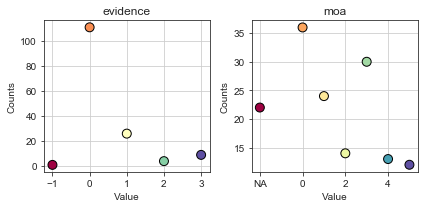

In [22]:
def barplot(ax, df, column):
    counts = collections.defaultdict(int)
    for r in df[column].values:
        counts[r] += 1
    keys = sorted(counts.keys())
    vals = [counts[k] for k in keys]
    ax.scatter(keys, vals, c=keys, cmap="Spectral", edgecolor="black", s=80)
    if column == "moa":
        xticks = ax.get_xticks()
        ax.set_xticks([-2, 0, 2, 4])
        ax.set_xticklabels(["NA", "0", "2", "4"])
    ax.set_title(column)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Value")

fig, axs = plt.subplots(1,2, figsize=(6,3))
axs = axs.flatten()

barplot(axs[0], df_lit, "evidence")
barplot(axs[1], df_lit, "moa")
plt.tight_layout()

## Ranking candidates

We have run the pipeline with:

* CC: Chemical Checker
* FP: Morgan Fingeprints (classical)

We compute matrices for:

* All evidence cutoffs
* All moas

Columns are:

* inchikey: candidate inchikey
* is_drug: yes (1), no (0)
* evidence: -2 (no evidence, most of the molecules), -1, 0, 1, 2, 3 (see spreadsheet)
* moa: -2 (no evidence, most of the molecules), 0, 1, 2, 3, 4, 5 (see spreadsheet)

Number of COVID molecules in:

* top_5: top 5 similarity
* lpv_5: -log p-value 5 (1e-5)
* lpv_4: -log p-value 4 (1e-4)
* lpv_3: -log p-value 3 (1e-3)
* lpv_2: -log p-value 2 (1e-2)

Finally:
* best_inchikey: COVID-19 molecule with the highest similarity to the candidate

In [82]:
def load_df(simtype, evidence, moa, sort_by):
    if evidence is None or evidence < 0:
        evi_suf = "eviall"
    else:
        evi_suf = "evi%d" % evidence
    if moa is None:
        moa_suf = "moaall"
    else:
        moa_suf = "moa%d" % moa
    fn = "../outputs/df_cand_%s_%s_%s.pkl" % (simtype, evi_suf, moa_suf)
    df = pickle.load(open(fn, "rb"))
    return df.sort_values(sort_by, ascending=False)

Based on FP similarity, considering *all* candidates and *all* moas, and focusing on a p-value of 1e-3.

In [87]:
load_df(simtype="fp", evidence=None, moa=None, sort_by="lpv_3")

,inchikey,name,is_drug,evidence,moa,top_5,lpv_5,lpv_4,lpv_3,lpv_2,best_inchikey,best_name
653299,WCZMIHAGTDDXBQ-CNTOOOFYSA-N,Chembl108807,0,-2,-2,0,0,2,9,9,AXRYRYVKAWYZBR-GASGPIRDSA-N,Atazanavir
169792,GHHGVZYSDDFVCE-QORCZRPOSA-N,Chembl326347,0,-2,-2,0,0,2,8,8,AXRYRYVKAWYZBR-GASGPIRDSA-N,Atazanavir
169791,GHHGVZYSDDFVCE-MHKFTUFMSA-N,Chembl324398,0,-2,-2,0,0,2,8,8,AXRYRYVKAWYZBR-GASGPIRDSA-N,Atazanavir
44261,BJSPSQYEAXWPOK-BBVRJQLQSA-N,Chembl2375147,0,-2,-2,0,0,1,7,7,ONJZYZYZIKTIEG-CFBQITSMSA-N,Sanglifehrin A
150061,FREXYXXOYJEUAY-PWKASRTISA-N,Chembl1790679,0,-2,-2,0,0,1,7,7,RJURFGZVJUQBHK-IIXSONLDSA-N,Dactinomycin
...,...,...,...,...,...,...,...,...,...,...,...,...
113054,DNHKRHGHMJZIBE-DEOSSOPVSA-N,Chembl451772,0,-2,-2,0,0,0,0,2,SGUAFYQXFOLMHL-UHFFFAOYSA-N,Labetalol
571432,SVASYEVXAOHGJV-UHFFFAOYSA-N,Ac1Nvypa,0,-2,-2,0,0,0,0,2,XASIMHXSUQUHLV-UHFFFAOYSA-N,Camostat
724034,YHXDKXSNJWEQRF-QEGGNFSNSA-N,Chembl143470,0,-2,-2,0,0,0,0,3,AXRYRYVKAWYZBR-GASGPIRDSA-N,Atazanavir
639003,VRKQBSISJQUWFI-QUYVBRFLSA-N,Maltose 1-Phosphate,0,-2,-2,0,0,0,0,3,MFMQRDLLSRLUJY-YMQHIKHWSA-N,Spectrum_001131


Based on CC similarities, considering only evidence >= 1 and moa = 3 (p-value of 1e-4)

In [88]:
load_df(simtype="cc", evidence=1, moa=3, sort_by="lpv_4")

,inchikey,name,is_drug,evidence,moa,top_5,lpv_5,lpv_4,lpv_3,lpv_2,best_inchikey,best_name
75417,CJBJHOAVZSMMDJ-HEXNFIEUSA-N,Darunavir,1,-2,-2,0,0,2,2,2,AMFDITJFBUXZQN-KUBHLMPHSA-N,Bcx4430 (Freebase)
367015,MLBVMOWEQCZNCC-OEMFJLHTSA-N,Fosamprenavir,1,-2,-2,0,0,2,2,2,AOCCBINRVIKJHY-UHFFFAOYSA-N,Carmofur
170649,GHYAMUIQUOQEJY-OWOJBTEDSA-N,GHYAMUIQUOQEJY-OWOJBTEDSA-N,0,-2,-2,0,0,1,1,1,AUZONCFQVSMFAP-UHFFFAOYSA-N,Disulfiram
592376,UFPKSFYXKOGZPA-UHFFFAOYSA-N,"1-Octene, 3-(Bromomethyl)-2,3,7-Trichloro-7-Me...",0,-2,-2,0,0,1,1,1,ACGUYXCXAPNIKK-UHFFFAOYSA-N,Hexachlorophene
89539,CUMBVUIXGKSPDS-UHFFFAOYSA-N,Chembl3093951,0,-2,-2,0,0,1,1,1,AXRYRYVKAWYZBR-GASGPIRDSA-N,Atazanavir
...,...,...,...,...,...,...,...,...,...,...,...,...
30023,AYDPZCGMCQBSDG-AHWVRZQESA-N,Pp5,0,-2,-2,0,0,0,1,1,AHOUBRCZNHFOSL-YOEHRIQHSA-N,Paroxetine
458254,PHAIUFIPJBFOPT-JYFOCSDGSA-N,Chembl326552,0,-2,-2,0,0,0,1,1,AUZONCFQVSMFAP-UHFFFAOYSA-N,Disulfiram
411984,NVURVEYEUBVDOO-MQGJPIDWSA-N,Chembl325944,0,-2,-2,0,0,0,1,1,AMFDITJFBUXZQN-KUBHLMPHSA-N,Bcx4430 (Freebase)
345656,LTPSUJWSMICZOD-ZDUSSCGKSA-N,Chembl2334305,0,-2,-2,0,0,0,1,1,AUZONCFQVSMFAP-UHFFFAOYSA-N,Disulfiram
